In [49]:
# Essential Imports
import pandas as pd
import numpy as np

# Pipeline for Scaling, Feature selection, and Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.impute import SimpleImputer

# Graphing and Metrics for Model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

### Examine Data to determine what needs to be cleaned

In [17]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Convert categorical data to 0 and 1 for regression and drop any NA values before feature selection (will be added back afterwards)

In [18]:
data_dummies = pd.get_dummies(df_train,dummy_na=True)
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputed_data = imputer.fit_transform(data_dummies)
data = pd.DataFrame(data=imputed_data, columns=imputer.get_feature_names_out()).drop(["Id","SalePrice"],axis=1)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Perform scaling and feature selection using an sklearn pipeline

In [19]:
# Scale data
scaler_data = StandardScaler()
scaler_data.fit(data)
data_scaled = scaler_data.transform(data)

scaler_y = StandardScaler()
scaler_y.fit(data_dummies[["SalePrice"]])
y_scaled = scaler_y.transform(data_dummies[["SalePrice"]])

scaler_data.get_feature_names_out()
x_scaled = pd.DataFrame(data=data_scaled,columns=scaler_data.get_feature_names_out())
x_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.073375,-0.229372,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.511418,0.575425,-0.288653,...,-0.045376,0.390293,0.0,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0
1,-0.872563,0.451936,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574410,1.171992,-0.288653,...,-0.045376,0.390293,0.0,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0
2,0.073375,-0.093110,0.073480,0.651479,-0.517200,0.984752,0.830215,0.323060,0.092907,-0.288653,...,-0.045376,0.390293,0.0,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0
3,0.309859,-0.456474,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,...,-0.045376,0.390293,0.0,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995,0.0
4,0.073375,0.633618,0.375148,1.374795,-0.517200,0.951632,0.733308,1.364570,0.463568,-0.288653,...,-0.045376,0.390293,0.0,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0


In [20]:
feature_selector = SelectKBest(score_func=f_regression, k=290)
x_new = feature_selector.fit_transform(x_scaled,y_scaled)

### Scale the test data based on the training data

In [21]:
test_dummies = pd.get_dummies(df_test,dummy_na=True)
test_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputed_test_data = test_imputer.fit_transform(test_dummies)
test = pd.DataFrame(data=imputed_test_data, columns=test_imputer.get_feature_names_out()).drop(["Id"],axis=1)
inclusion_columns = set(feature_selector.get_feature_names_out()) & set(test.columns)

new_scaler = StandardScaler()
new_scaler.fit(data.filter(items=inclusion_columns))
new_data = new_scaler.transform(data.filter(items=inclusion_columns))
x_test = new_scaler.transform(test.filter(items=inclusion_columns))

### Linear Regression

In [22]:
regressor = LinearRegression()
regressor.fit(X=new_data,y=y_scaled)
y_pred = regressor.predict(X=new_data)
r2_score(y_scaled, y_pred)

0.8697455462662562

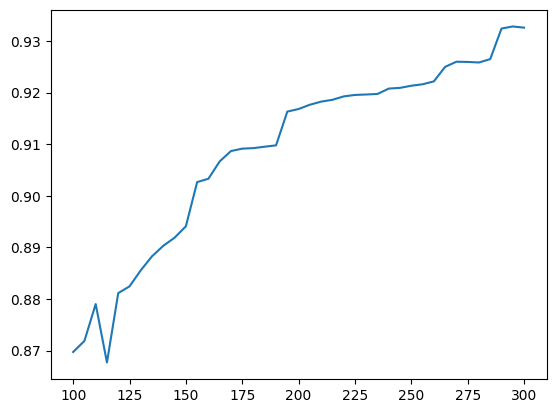

In [34]:
r2_list = []
max_features = 301
for i in range(100,max_features,5):
    feature_selector = SelectKBest(score_func=f_regression, k=i)
    x_new = feature_selector.fit_transform(x_scaled,y_scaled)
    new_scaler = StandardScaler()
    new_data = new_scaler.fit_transform(data.filter(items=feature_selector.get_feature_names_out()))
    regressor = LinearRegression()
    regressor.fit(X=new_data,y=y_scaled)
    y_pred = regressor.predict(X=new_data)
    r2_list.append(r2_score(y_scaled, y_pred))
plt.plot(range(100,max_features,5),r2_list)

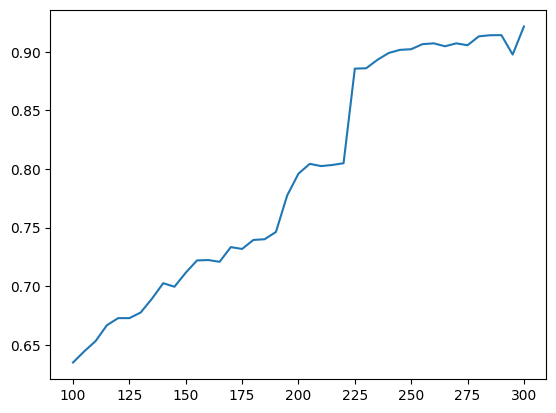

In [50]:
r2_list = []
max_features = 301
for i in range(100,max_features,5):
    regressor = LinearRegression()
    feature_selector = RFE(estimator=regressor, n_features_to_select=i,step=1)
    x_new = feature_selector.fit_transform(x_scaled,y_scaled)
    new_scaler = StandardScaler()
    new_data = new_scaler.fit_transform(data.filter(items=feature_selector.get_feature_names_out()))
    regressor.fit(X=new_data,y=y_scaled)
    y_pred = regressor.predict(X=new_data)
    r2_list.append(r2_score(y_scaled, y_pred))
plt.plot(range(100,max_features,5),r2_list)

In [40]:
feature_selector = SelectKBest(score_func=f_regression, k=288)
x_new = feature_selector.fit_transform(x_scaled,y_scaled)
new_scaler = StandardScaler()
new_data = new_scaler.fit_transform(data.filter(items=feature_selector.get_feature_names_out()))
regressor = LinearRegression()
regressor.fit(X=new_data,y=y_scaled)
y_pred = regressor.predict(X=new_data)
r2_score(y_scaled, y_pred)

0.9317804752382839

In [48]:
inclusion_columns = set(feature_selector.get_feature_names_out()) & set(test.columns)
new_scaler = StandardScaler()
new_scaler.fit(data.filter(items=inclusion_columns))
new_data = new_scaler.transform(data.filter(items=inclusion_columns))
x_test = new_scaler.transform(test.filter(items=inclusion_columns))
regressor = LinearRegression()
regressor.fit(X=new_data,y=y_scaled)
y_pred = regressor.predict(X=x_test)
pd.Series(scaler_y.inverse_transform(predicted.reshape(-1,1)).flatten()).to_clipboard()